# EE461P Term Project

## [Quora Kaggle](https://www.kaggle.com/c/quora-insincere-questions-classification)

## [Toxic Comments Kaggle (for NLP ideas)](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge)

### Embeddings
External data sources are not allowed for this competition. We are, though, providing a number of word embeddings along with the dataset that can be used in the models. These are as follows:

GoogleNews-vectors-negative300 - https://code.google.com/archive/p/word2vec/

glove.840B.300d - https://nlp.stanford.edu/projects/glove/

paragram_300_sl999 - https://cogcomp.org/page/resource_view/106

wiki-news-300d-1M - https://fasttext.cc/docs/en/english-vectors.html

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score, train_test_split, cross_val_predict, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier, ExtraTreesClassifier
import xgboost as xgb
from sklearn import preprocessing
import pprint

%matplotlib inline

In [2]:
# Load the data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train_qid = train['qid']
test_qid  = test['qid']
y_train = train['target']

train.drop("qid", axis = 1, inplace = True)
test.drop("qid", axis = 1, inplace = True)

train.head()

,question_text,target
0,How did Quebec nationalists see their province...,0
1,"Do you have an adopted dog, how would you enco...",0
2,Why does velocity affect time? Does velocity a...,0
3,How did Otto von Guericke used the Magdeburg h...,0
4,Can I convert montra helicon D to a mountain b...,0


## Feature Engineering:

In [3]:
# Concat training and set set for data exploration and feature engineering
all_data = pd.DataFrame(pd.concat((train['question_text'], test['question_text'])))

In [4]:
print("Total Insincere Questions: ", sum(y_train))
print("Total Sincere Questions: ", len(y_train) - sum(y_train))

Total Insincere Questions:  80810
Total Sincere Questions:  1225312


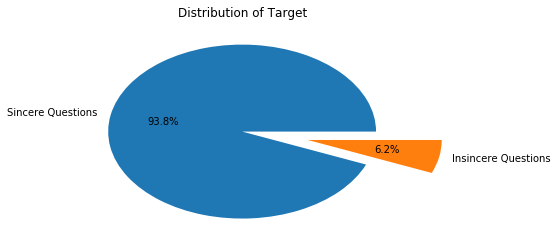

In [5]:
plt.pie([len(y_train) - sum(y_train), sum(y_train)],
        explode = (0, 0.5),
        labels=["Sincere Questions", "Insincere Questions"],
        autopct='%1.1f%%');
plt.title("Distribution of Target");

In [39]:
from wordcloud import WordCloud, STOPWORDS

# Thanks : https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##
def plot_wordcloud(text, mask=None, max_words=250, max_font_size=150, min_font_size = 10, figure_size=(60,40), 
                   title = None, title_size=40, image_color=False,
                   colormap = "viridis", background_color="white"):
    
    stopwords = set(STOPWORDS)
    stopwords = stopwords.union({'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'})

    wordcloud = WordCloud(background_color=background_color,
                          stopwords = stopwords,
                          max_words = max_words,
                          max_font_size = max_font_size, 
                          min_font_size = min_font_size,
                          random_state = 42,
                          width=2000, 
                          height=1500,
                          mask = mask,
                          colormap=colormap)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  

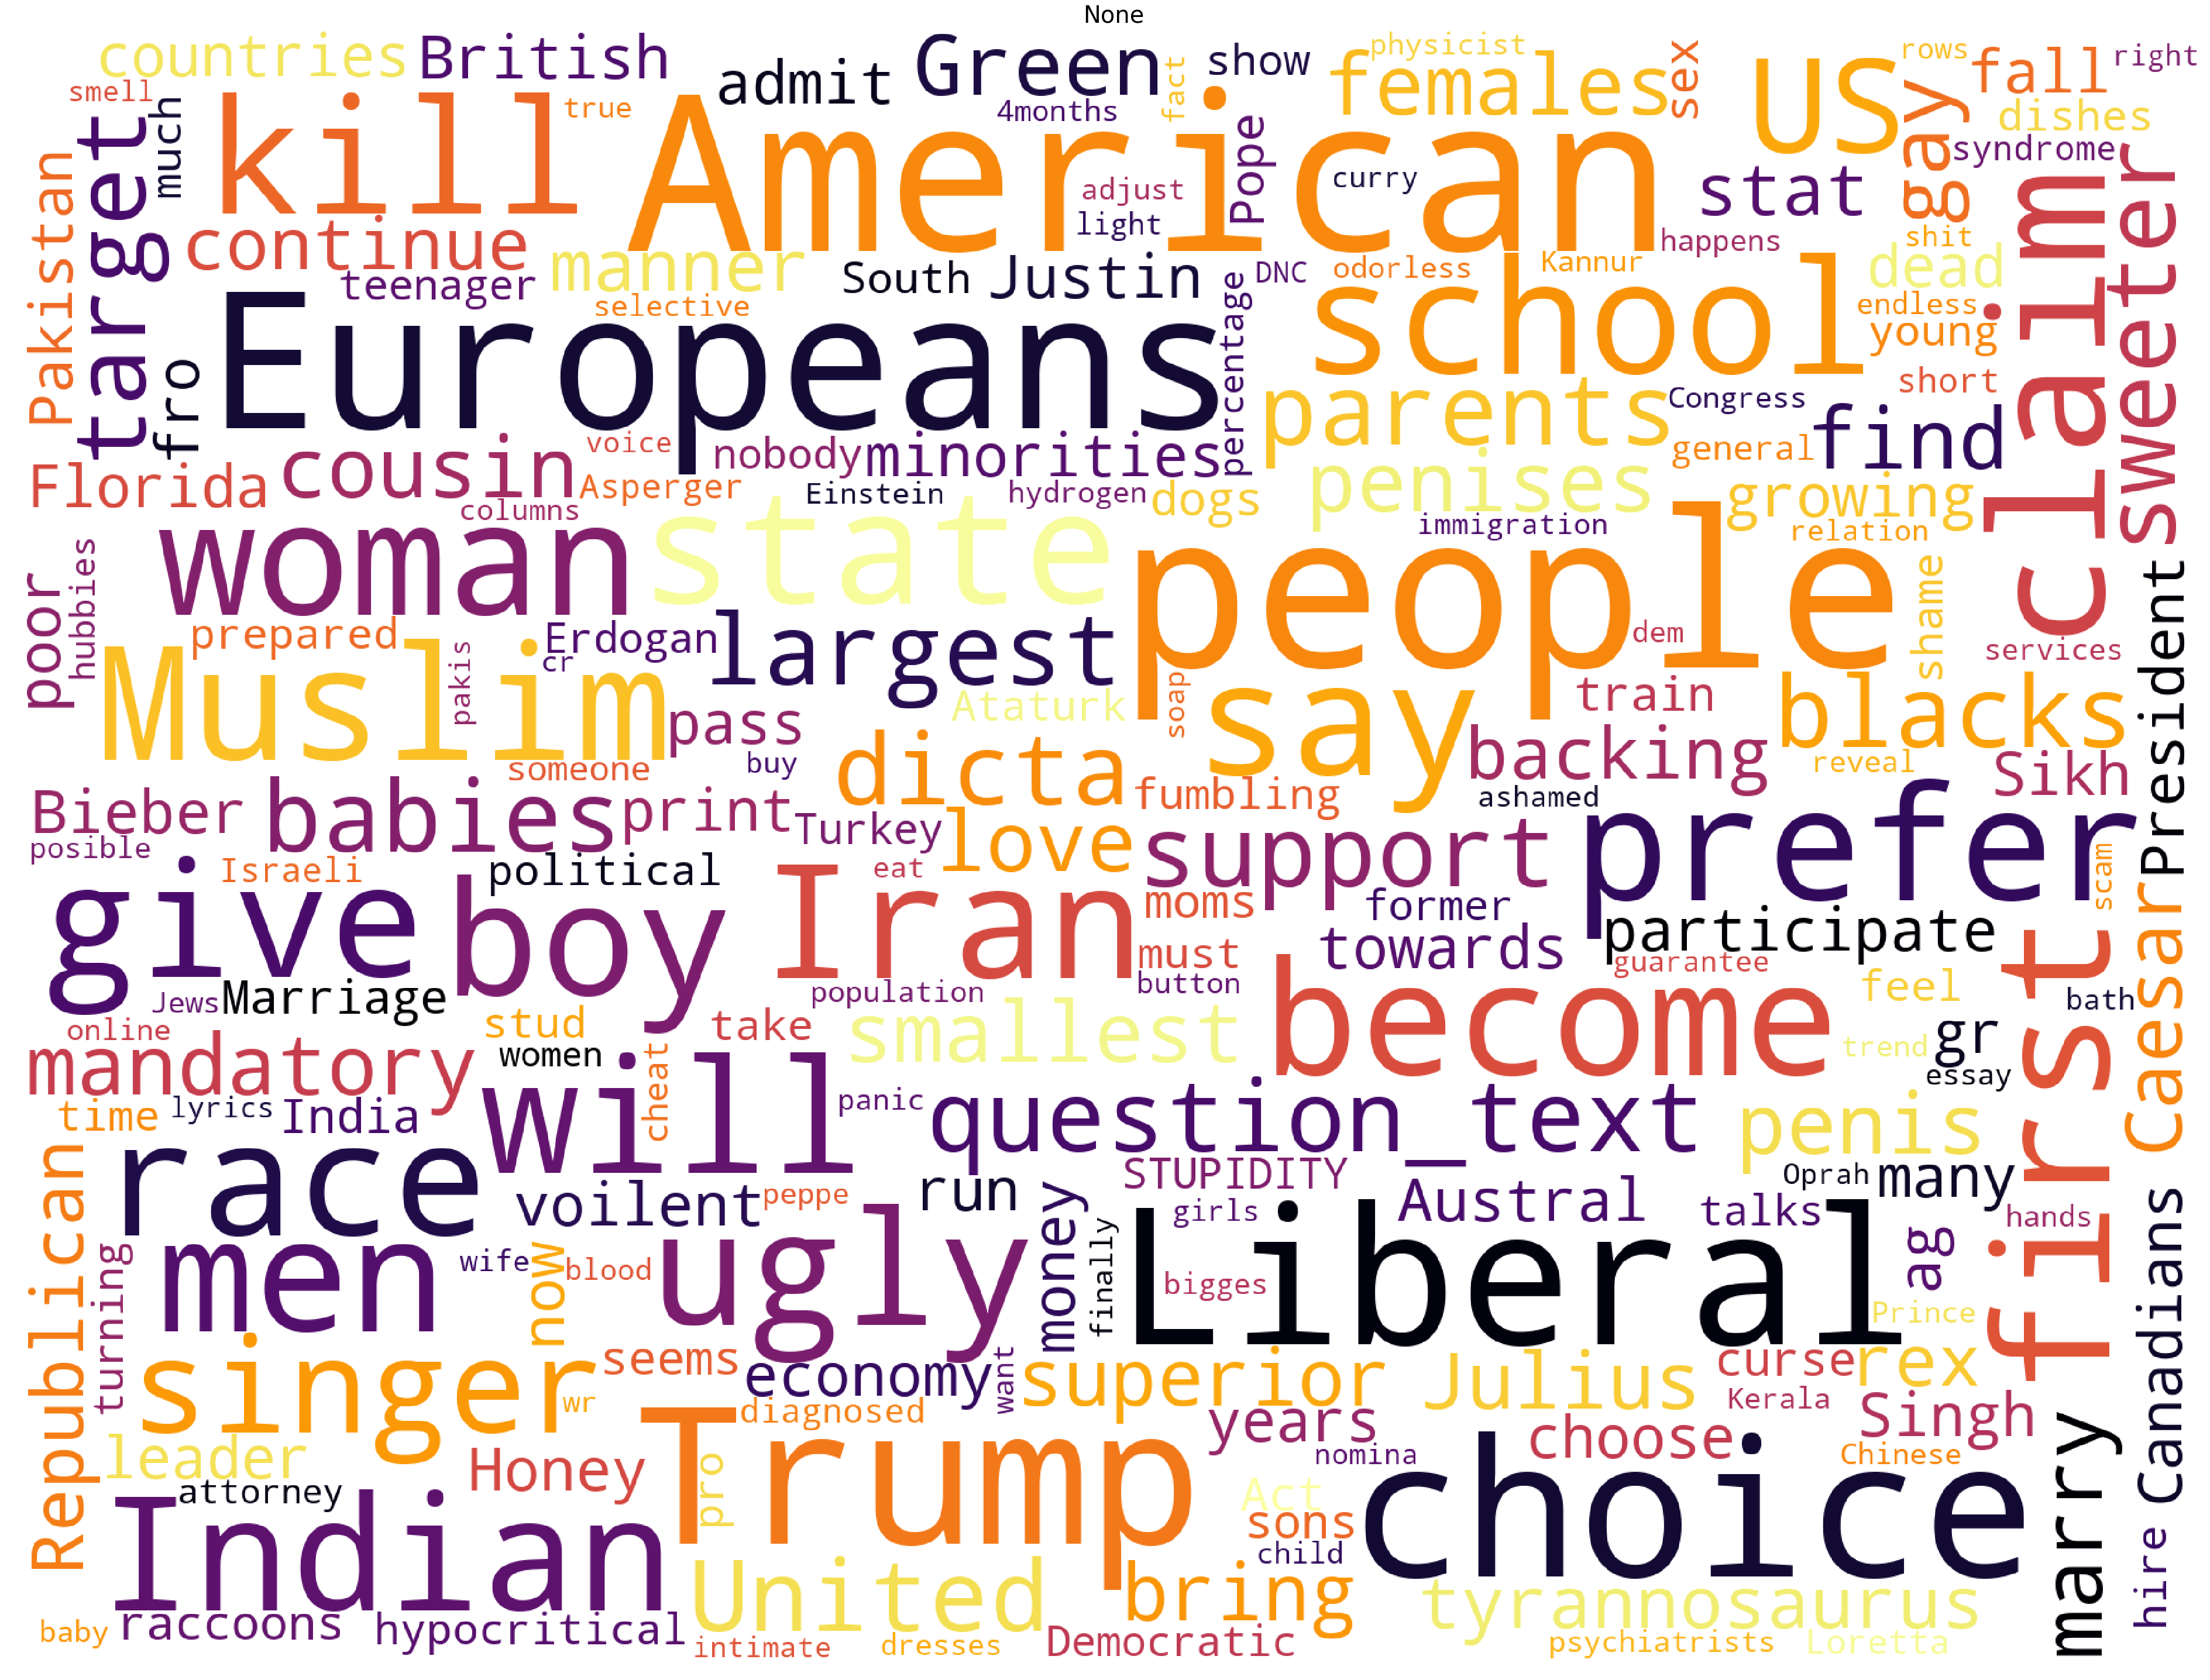

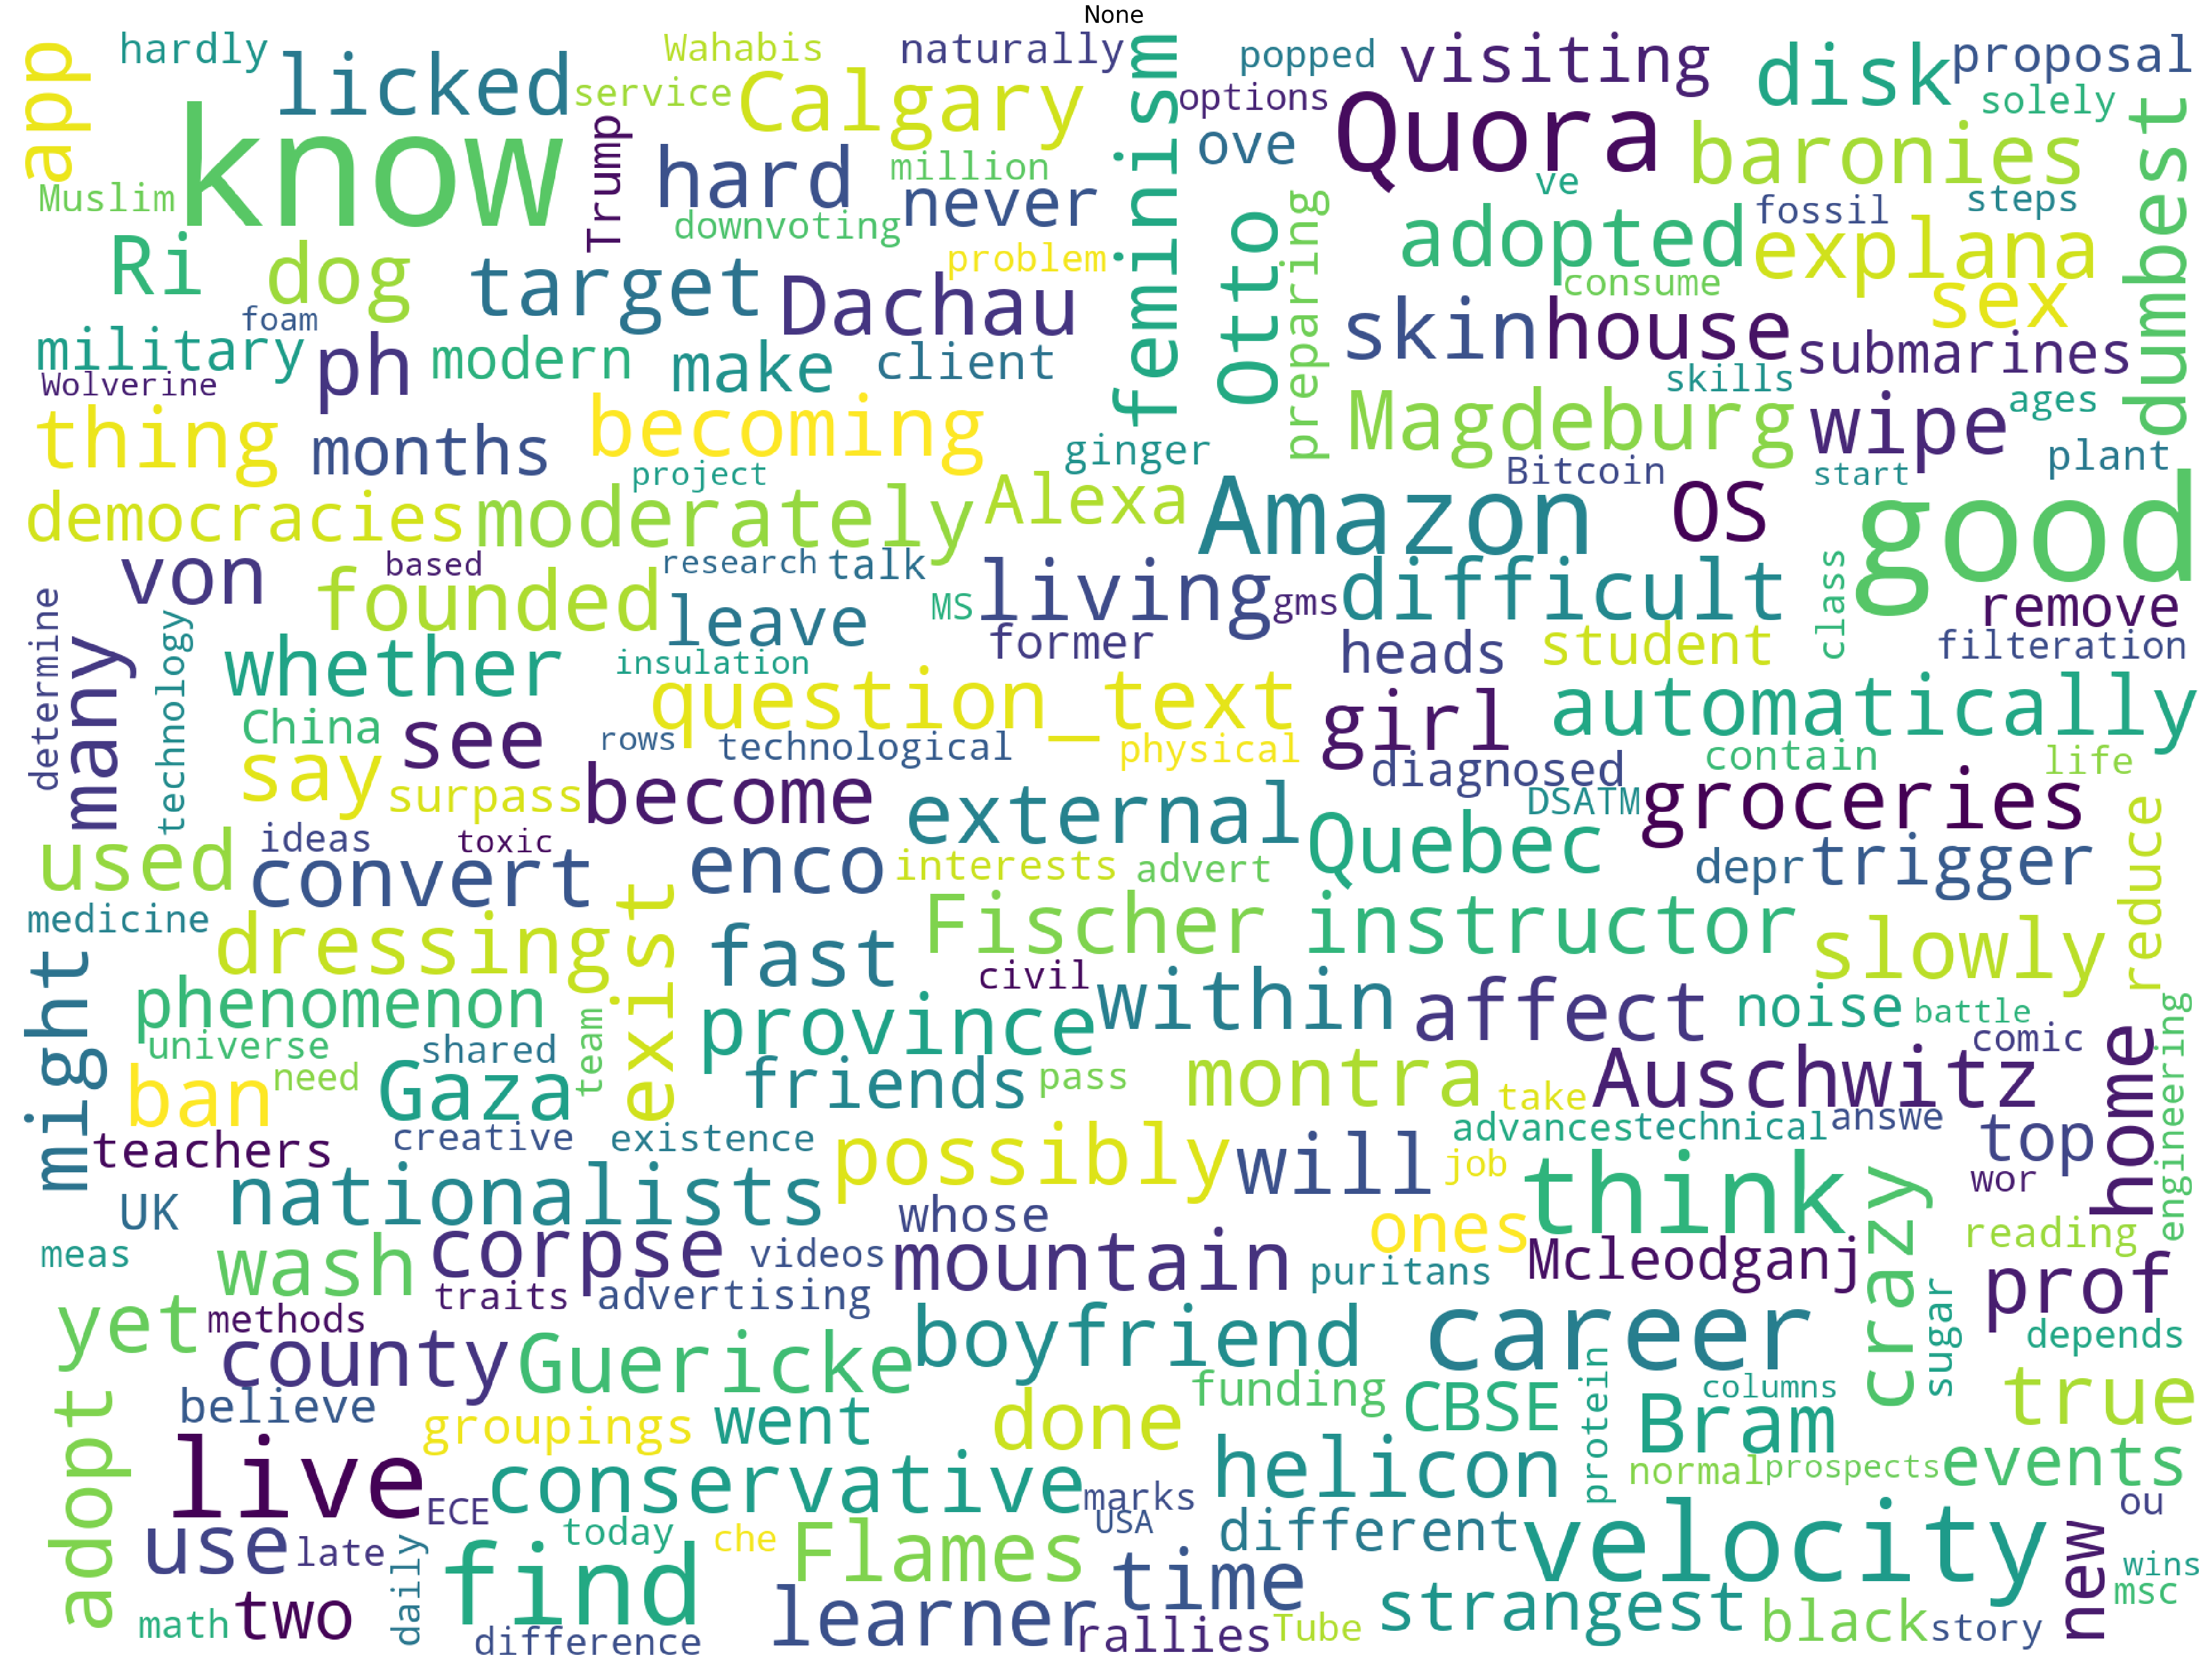

In [41]:
bad_questions = train.loc[train['target'] == 1]

plot_wordcloud(bad_questions, colormap = "inferno", background_color = "white",
               max_words = 2000,
               max_font_size = 200, min_font_size = 15)

good_questions = train.loc[train['target'] == 0]

plot_wordcloud(good_questions, colormap = "viridis", background_color = "white", 
               max_words = 2000,
               max_font_size = 150, min_font_size = 15)

In [46]:
from collections import defaultdict

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

def word_freq(dataframe0, dataframe1, n):
    ## Get the bar chart from sincere questions ##
    freq_dict = defaultdict(int)
    for sent in dataframe0["question_text"]:
        for word in generate_ngrams(sent, n_gram=n):
            freq_dict[word] += 1
    fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
    fd_sorted.columns = ["word", "wordcount"]
    fd_sorted.to_csv('Frequent_Sincere' + str(n) + '.csv')

    ## Get the bar chart from insincere questions ##
    freq_dict = defaultdict(int)
    for sent in dataframe1["question_text"]:
        for word in generate_ngrams(sent, n_gram=n):
            freq_dict[word] += 1
    fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
    fd_sorted.columns = ["word", "wordcount"]
    fd_sorted.to_csv('Frequent_Insincere' + str(n) + '.csv')


In [47]:
train1_df = train[train["target"] == 1]
train0_df = train[train["target"] == 0]

word_freq(train0_df, train1_df, 1)

In [48]:
word_freq(train0_df, train1_df, 2)

In [49]:
word_freq(train0_df, train1_df, 3)

In [12]:
import string

## Number of words in the text ##
train["num_words"] = train["question_text"].apply(lambda x: len(str(x).split()))
test["num_words"] = test["question_text"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text ##
train["num_unique_words"] = train["question_text"].apply(lambda x: len(set(str(x).split())))
test["num_unique_words"] = test["question_text"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the text ##
train["num_chars"] = train["question_text"].apply(lambda x: len(str(x)))
test["num_chars"] = test["question_text"].apply(lambda x: len(str(x)))

## Number of stopwords in the text ##
train["num_stopwords"] = train["question_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
test["num_stopwords"] = test["question_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

## Number of punctuations in the text ##
train["num_punctuations"] = train['question_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test["num_punctuations"] = test['question_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Number of title case words in the text ##
train["num_words_upper"] = train["question_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test["num_words_upper"] = test["question_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the text ##
train["num_words_title"] = train["question_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test["num_words_title"] = test["question_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the text ##
train["mean_word_len"] = train["question_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test["mean_word_len"] = test["question_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [13]:
from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgb

# Get the tfidf vectors #
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
tfidf_vec.fit_transform(train['question_text'].values.tolist() + test['question_text'].values.tolist())
train_tfidf = tfidf_vec.transform(train['question_text'].values.tolist())
test_tfidf = tfidf_vec.transform(test['question_text'].values.tolist())

In [20]:
def eval_model(model, train_set):
    print("Building model.")
    cv_scores = []
    pred_train = np.zeros([train.shape[0]])
    kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
    
    for train_index, val_index in kf.split(train_set):
        train_X, val_X = train_set[train_index], train_set[val_index]
        train_y, val_y = y_train[train_index], y_train[val_index]
        
        model.fit(train_X, train_y)
        pred_val_y = model.predict_proba(val_X)[:,1]
        
        pred_train[val_index] = pred_val_y
        cv_scores.append(metrics.f1_score(val_y, (pred_val_y>0.5).astype(int)))
        
    print(cv_scores)

In [21]:
lr_model = linear_model.LogisticRegression(C=5., solver='sag')

eval_model(lr_model, train_tfidf)

Building model.
[0.45172874561550025, 0.4513149134487349, 0.447571720883618, 0.4484388185654009, 0.45269299061469515]


In [ ]:
for thresh in np.arange(0.05, 0.201, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(y_train, (pred_train>thresh).astype(int))))

In [ ]:
import eli5
eli5.show_weights(model, vec=tfidf_vec, top=100, feature_filter=lambda x: x != '<BIAS>')

## Functions:

In [ ]:
# Will run 5-fold cross validation evaluated with the F1 Score
# model: model to cross-validate 
# train_set: training set being used to validate model
def f1_cv(model, train_set):
    kf = KFold(5, shuffle=True, random_state=0).get_n_splits(train_set)
    f1_score = cross_val_score(model, train_set, y_train, scoring="f1", cv = kf)
    return f1_score.mean()

In [ ]:
# Generates a submission file from predictions of the given model on the test set
def gen_sub(name, model):
    y_pred = model.predict(X_test)
    solution = pd.DataFrame({"qid":test_qid, "prediction":y_pred})
    solution.to_csv(name +".csv", index = False)

## Models:

In [ ]:
# split the data back into original train and test set
X_train = all_data[:train_qid.size]
X_test = all_data[train_qid.size:]
y_train = y_train

In [ ]:
# first model code here...